In [1]:
import os
import sys

try:
    if not os.path.isdir('/content/pyTorchWrapper'):
        raise FileNotFoundError
except FileNotFoundError:
    print("(◕‿◕✿) Downloading pyTorchWrapper from GitHub.")
    os.system(f'git clone https://github.com/shuliu2017/pyTorchWrapper.git')
except Exception as e:
    print(f"(◕‿◕✿) An unexpected error occurred: {e}")

sys.path.append('/content/pyTorchWrapper')

(◕‿◕✿) Downloading pyTorchWrapper from GitHub.


In [2]:
!pip install -r /content/pyTorchWrapper/requirements.txt

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [3]:
%load_ext autoreload
%autoreload 2

import simple_torch_wrapper as  stw

In [4]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import numpy as np
import transformers

# Create a synthetic dataset class
class SyntheticImageDataset(Dataset):
    def __init__(self, transform=None):
        self.transform = transform

    def __len__(self):
        return 1000  # Total number of synthetic images

    def __getitem__(self, idx):
        # Generate a synthetic image and a continuous target value
        image = np.random.rand(128, 128, 3) * 255
        target = np.mean(image) / 255  # Example regression target

        image = Image.fromarray(image.astype('uint8')).convert('RGB')

        if self.transform:
            image = self.transform(image)
        target = torch.tensor(target, dtype=torch.float32)

        return image, target

image_processor = transformers.AutoImageProcessor.from_pretrained('google/vit-base-patch16-224')

crop_size=(image_processor.size["height"],image_processor.size["width"])
normalize =transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)

transform = transforms.Compose([
    transforms.Resize(crop_size),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32),
    normalize,
])

# Create the full dataset
full_dataset = SyntheticImageDataset(transform=transform)

# Define the sizes for train, validation, and test sets
train_size = int(0.7 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Create DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print the sizes of each set to verify
print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Train set size: 700
Validation set size: 200
Test set size: 100


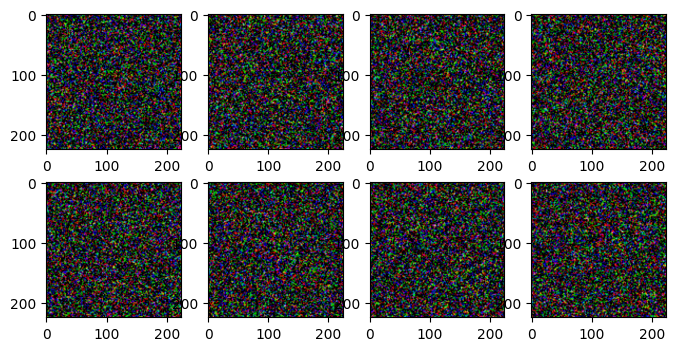

In [5]:
data_iter = iter(train_loader)
first_batch = next(data_iter)
images, targets = first_batch

fig, ax = plt.subplots(2, 4, figsize=(8,4))
ax = ax.flat
for i in range(8):
    ax[i].imshow(images[i].permute(1, 2, 0))

(array([  8.,  35.,  88., 121., 175., 147.,  83.,  27.,  12.,   4.]),
 array([0.49618554, 0.49701169, 0.49783784, 0.49866402, 0.49949017,
        0.50031632, 0.5011425 , 0.50196862, 0.5027948 , 0.50362092,
        0.5044471 ]),
 <BarContainer object of 10 artists>)

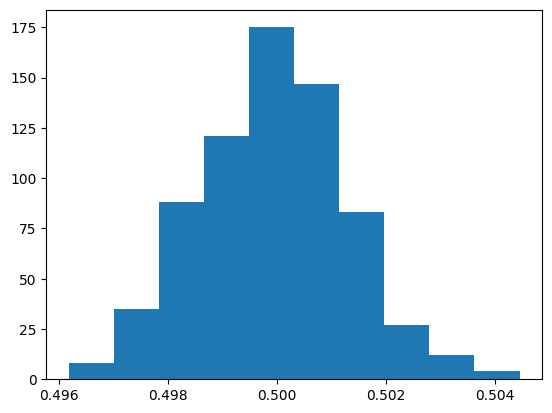

In [6]:
y_ls = []
for i, (X, y) in enumerate(train_loader):
    y_ls.extend(y.detach().cpu().numpy())
y_arr = np.array(y_ls)
plt.hist(y_arr)

In [7]:
epochs = 6

stw.pytorch_tools.set_random_seed(seed=0)

model = stw.models.vit_regressor.ViTRegressor()
device = stw.pytorch_tools.get_device()
model = model.to(device)
model = stw.pytorch_tools.enable_multi_gpu(model)

model_name = 'vit_regressor'
loss_fn = torch.nn.MSELoss()
task_type = 'regression'

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
early_stopping = stw.workflow.EarlyStopping(patience=8)
metrics = stw.customized_metrics.regression_metrics
result = stw.workflow.train(model=model,
                                  train_dataloader=train_loader,
                                  validation_dataloader=val_loader,
                                  optimizer=optimizer,
                                  loss_fn=loss_fn,
                                  metrics=metrics,
                                  task_type=task_type,
                                  epochs=epochs,
                                  early_stopping=early_stopping,
                                  save_freq=2,
                                  device=device)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

(◕‿◕✿) Using 1 GPUs.


  0%|          | 0/6 [00:00<?, ?it/s]

(◕‿◕✿) Epoch 1: Initial Validation loss (0.017580).
    (◕‿◕✿) Epoch 1: Save model to model_checkpoint.pt.
(◕‿◕✿) Epoch 2: Validation loss decreased (0.017580 --> 0.000619).
(◕‿◕✿) Epoch 3: EarlyStopping counter: 1 out of 8
    (◕‿◕✿) Epoch 3: Save model to model_checkpoint.pt.
(◕‿◕✿) Epoch 4: EarlyStopping counter: 2 out of 8
(◕‿◕✿) Epoch 5: Validation loss decreased (0.000619 --> 0.000461).
    (◕‿◕✿) Epoch 5: Save model to model_checkpoint.pt.
(◕‿◕✿) Epoch 6: Validation loss decreased (0.000461 --> 0.000333).


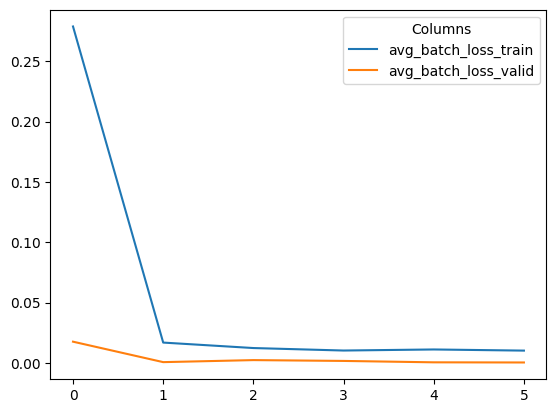

In [8]:
import matplotlib.pyplot as plt

# Line plot for multiple columns
result[['avg_batch_loss_train', 'avg_batch_loss_valid']].plot(kind='line')
plt.legend(title='Columns')
plt.show()

In [9]:
test_model = stw.models.vit_regressor.ViTRegressor().to(device)
stw.pytorch_tools.load_model_state(test_model, target_dir='/content', model_name= f'model_checkpoint.pt')
test_result = stw.workflow.evaluation_step(test_model, test_loader, loss_fn, metrics, task_type, device)

Model state loaded from /content/model_checkpoint.pt


In [10]:
test_result

{'avg_batch_loss': 0.000608836067840457,
 'mean_squared_error': 0.00060103484,
 'r2_score': -426.398139261358,
 'mean_absolute_error': 0.020111337}